In [1]:
%pylab inline

# Import a bunch of stuff to ease command line usage.
from tvb.simulator.lab import *
from tvb.simulator.models.epileptor_rs import EpileptorRestingState
from tvb.datatypes.time_series import TimeSeriesRegion
import numpy as np
import time as tm
import matplotlib.pyplot as plt 
import sys

Populating the interactive namespace from numpy and matplotlib


In [ ]:
? EpileptorRestingState

In [3]:
# Initialise the Connectivity.
con = connectivity.Connectivity.from_file('connectivity_76.zip')      
nregions = len(con.region_labels)                               #number of regions
con.weights = con.weights - con.weights * eye((nregions))       #remove self-connection
con.speed = np.array([1])                      #set conduction speed (here we neglect it)
con.configure()
#这里的connevtivity指的是76个部分之间的连接，我们还可以选择66，68，96和192的连接

WARNING  File 'hemispheres' not found in ZIP.


In [4]:
print(np.array([1]))


[1]


In [5]:
sys.float_info.max
print(con.speed)

[1.]


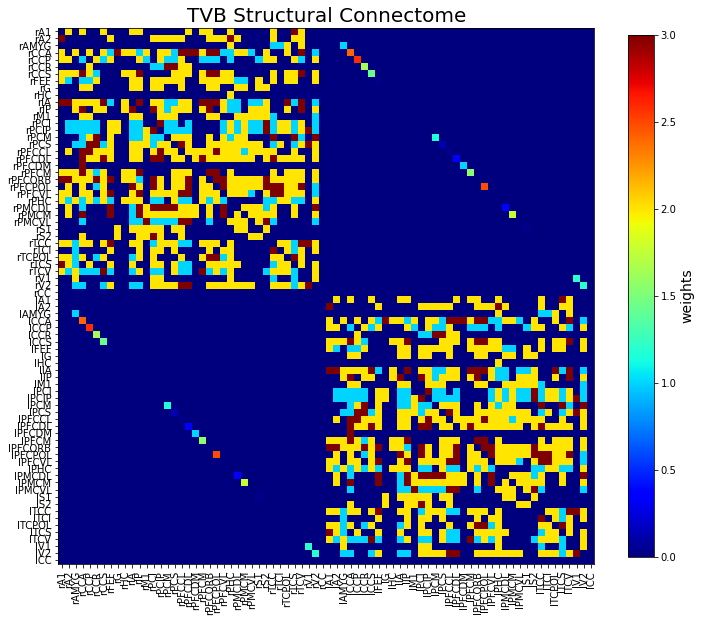

In [6]:
# Visualization.
figure(figsize=(12,12))
imshow(con.weights, interpolation='nearest', aspect='equal', cmap='jet')
title('TVB Structural Connectome', fontsize=20)
xticks(range(0, nregions), con.region_labels, fontsize=10, rotation=90)
yticks(range(0, nregions), con.region_labels, fontsize=10)
cb=colorbar(shrink=0.8)
cb.set_label('weights', fontsize=14)
show()

In [9]:
#con.weights[40][70],con.weights[40][72],
#con.weights[47][62]
#con.weights[62]([74],[70],[69],[60])

In [12]:
mod = EpileptorRestingState(Ks=np.array([-0.1]), r=np.array([0.000015]), tau=np.array([1000]), K_rs=np.array([0.1]))
mod.a_rs = np.ones((nregions)) * (1.7402) 

In [13]:
from tvb.simulator.models.epileptor import Epileptor
# ?EpileptorRestingState

In [14]:
# Heatmap of epileptogenicity and related parameters.
mod.x0 = np.ones((nregions)) * (-3)          #NIZ
mod.x0[[40]] = np.ones((1)) * (-1.4)           #EZ: lAMYG
mod.x0[[62]] = np.ones((1)) * (-1.4)       #EZ: lHC, lPHC
#mod.x0[[69]] = np.ones((1)) * (-2.9)           #PZ: lTCI
mod.x0[[70,74,69,60]] = np.ones((4)) * (-2.9)           #PZ: lTCV
##修改
#mod.x0[[63]] = np.ones((1))*(-1.4)

mod.bb = np.ones((nregions)) * (4)             #NIZ
mod.bb[[40,62]] = np.ones((2)) * (1)      #EZ
mod.bb[[70,74,69,60]] = np.ones((4)) * (2)          #PZ

#mod.bb[[63]] = np.ones((1))*4

mod.p = np.ones((nregions)) * (0.1)            #NIZ
#mod.p[[40, 62]] = np.ones((2)) * (0.9)     #EZ
#mod.p[[70,74,69,60]] = np.ones((4)) * (0.7)         #PZ

#mod.p[[63]] = np.ones((1))*0.9

#我不知道bb是干什么的，我也不知道p的LFP是干什么的
#把a的值从初始值升高一点点可以达到inter spike的效果

In [15]:
coupl = 1
con_coupling = coupling.Difference(a=np.array([coupl]))
#con_coupling是一个coupling.difference函数，这样的函数还有很多，coupling是simulator里面需要的一个变量，是为了让模型的输入更符合要求

In [16]:
# Initialise an Integrator scheme.
dt = 0.1                  #integration steps [ms]
nsigma1 = 0.00025         #standard deviation of the noise
nsigma2 = 0.001

hiss = noise.Additive(nsig=np.array([0., 0., 0., nsigma1, nsigma1, 0., nsigma2, 0.]))
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)
#这个integrator也是simulator的一个参数，用来计算模型变量岁时间的变化

In [17]:
# Initialise some Monitors with period in physical time.
mon_tavg = monitors.TemporalAverage(period=1) #in ms  

# Bundle them
what_to_watch = (mon_tavg)

#monitor是simulator的一个参数，通过改变monitor我们可以决定在simulator的过程中收集那些数据。


这样我们就完成了simulate数据前的一些准备工作

In [18]:
# Initialise the Simulator.
sim = simulator.Simulator(model=mod,
                          connectivity=con,
                          conduction_speed=np.float(con.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=[what_to_watch])
sim.configure()

,value
Type,Simulator
conduction_speed,1.0
connectivity,Connectivity gid: 3936b852-f9a0-4ab1-81ad-5fbfa02f60a2
coupling,Difference gid: 7ecca179-106e-4ea5-b791-18b85f5e52c7
gid,UUID('2b744227-1682-4300-95de-668a162b3223')
initial_conditions,None
integrator,HeunStochastic gid: 281e7ec5-e44e-497a-8e62-f459bf64d6e7
model,EpileptorRestingState gid: 4842a980-af4e-4822-9da8-ee81cca991d9
monitors,[]
simulation_length,1000.0


In [19]:
tic = tm.time()

tavg_time, tavg_data = [], []
for tavg in sim(simulation_length=1000):
    if not tavg is None:
        tavg_time.append(tavg[0][0])
        tavg_data.append(tavg[0][1])
    
'simulation required %0.3f seconds.' % (tm.time()-tic)
#simulate的速度和con。speed没有关系，指和长度有关系

'simulation required 2.405 seconds.'

In [20]:
# Normalize time series
tavg_data /= (np.max(tavg_data, 0) - np.min(tavg_data, 0))
tavg_data -= np.mean(tavg_data, 0)

# Make lists numpy.arrays for easier use.  
TAVG = np.squeeze(np.array(tavg_data))
TAVG.shape

(1000, 3, 76)

In [21]:
# # Compute LFP output model.
DATA = mod.p[[0]] * TAVG[:, 0, :] + (1 - mod.p[[0]]) * TAVG[:, 2, :]

EZs = [62 ,40]
for ie, ez in enumerate(EZs):
    DATA[:, EZs[ie]] = mod.p[[EZs[ie]]] * TAVG[:, 0, EZs[ie]] + (1 - mod.p[[EZs[ie]]]) * TAVG[:, 2, EZs[ie]]
    
PZs = [70,74,69,60]
for ip, pz in enumerate(PZs):
    DATA[:, PZs[ip]] = mod.p[[PZs[ip]]] * TAVG[:, 0, PZs[ip]] + (1 - mod.p[[PZs[ip]]]) * TAVG[:, 2, PZs[ip]]
    


In [22]:
(DATA).shape

(1000, 76)

0 62
1 40


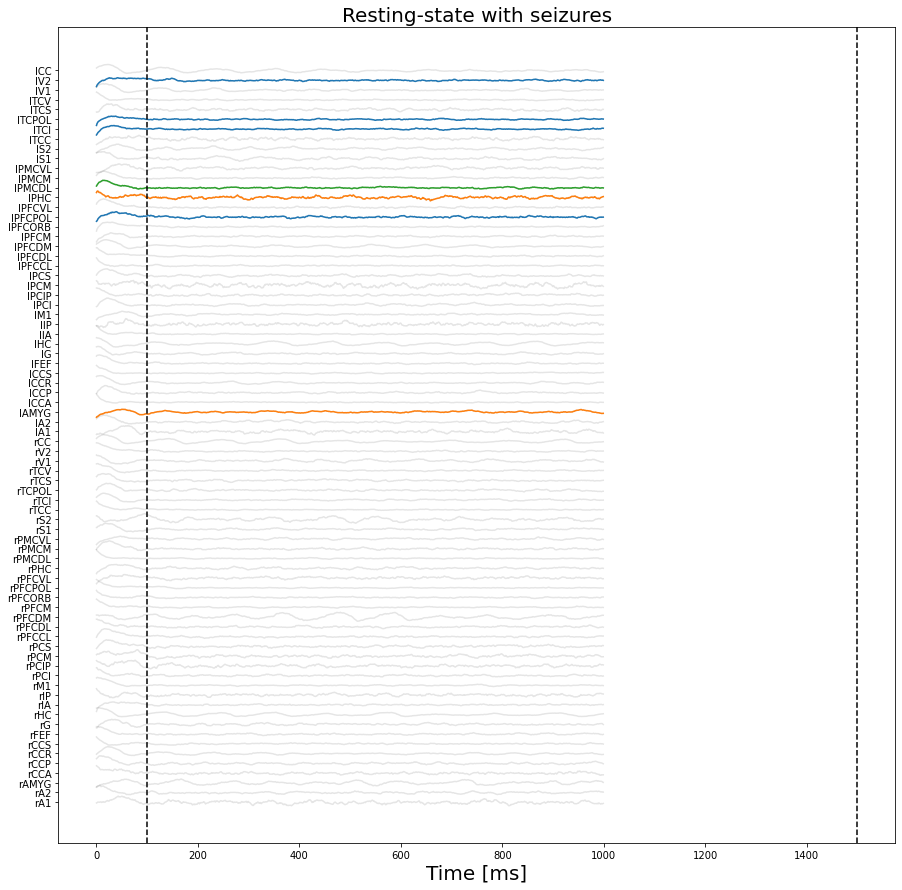

In [23]:
# Plot time series.
fig1 = plt.figure(figsize=(15,15))
plt.plot(DATA[:, :] + r_[:nregions], 'k', alpha=0.1)
plt.yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=10)

EZs = [62, 40]
for ie, ez in enumerate(EZs):
    plt.plot(DATA[:, EZs[ie]] + EZs[ie], 'C1')
    print(ie,ez)
PZs = [70,74,69,60]
for ip, pz in enumerate(PZs):
    plt.plot(DATA[:, PZs[ip]] + PZs[ip], 'C0')
    
plt.plot(DATA[:,63]+63,'C2')
    
plt.axvline(x=100, color='k', linestyle='--')
plt.axvline(x=1500, color='k', linestyle='--')
    
plt.title('Resting-state with seizures', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)

plt.show()

ValueError: x and y must have same first dimension, but have shapes (7900,) and (900,)

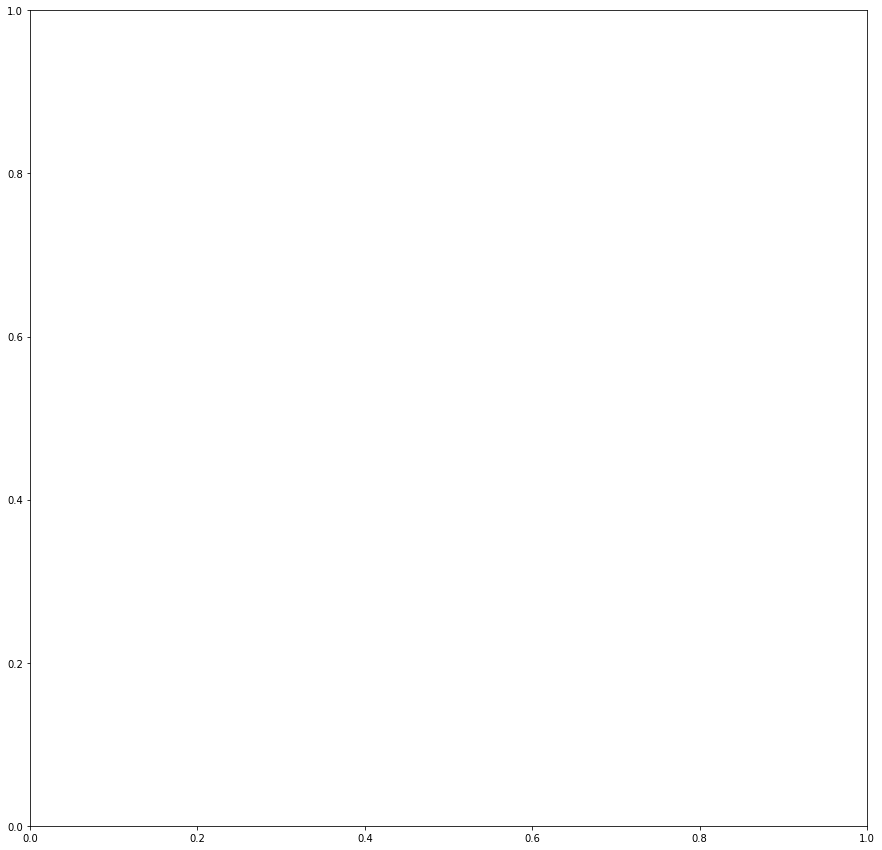

In [24]:
# Zoom.
EN = [62, 40, 70,74,69,60,63]
idx = np.arange(len(EN))

fig2 = plt.figure(figsize=(15,15))
for ie, en in enumerate(EN):
    plt.plot(np.arange(100, 8000), DATA[100:8000, EN[ie]] + idx[ie], 'k', alpha=0.5)
plt.title('Epileptogenic Network time series', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)
plt.yticks(np.arange(len(EN)), con.region_labels[EN])

for ie, en in enumerate(EN):
    plt.plot(np.arange(15000, 30000), DATA[15000:30000, EN[ie]] + idx[ie], 'k', alpha=0.5)
plt.title('Epileptogenic Network time series', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)
plt.yticks(np.arange(len(EN)), con.region_labels[EN])

plt.show()

**现在开始给予特定的region刺激**

In [43]:
weighting = numpy.zeros((76, ))
weighting[[27, 28, 34, 35, 36]] = 0.3
#这几个区是海马体所在的区域，我感觉weighting是不是刺激强度的意思啊

eqn_t = equations.PulseTrain()#一种stimulus的形式，还有很多别的模式
eqn_t.parameters['onset'] = 1.5e3#开始的时间
eqn_t.parameters['T'] = 10#周期
eqn_t.parameters['tau'] = 1.0#一次冲击持续的时间

In [33]:
?eqn_t

Type:           PulseTrain
String form:   
PulseTrain (
  Equation type  PulseTrain
  equation .... where((var>onset)&(((var-onset) % T) < tau), amp, 0)
  parameters .. {'T': 1000.0, 'tau': 10.0, 'amp': 1.0, 'onset': 1500.0}
)
File:           c:\users\g-son\anaconda3\envs\tvb-run\lib\site-packages\tvb\datatypes\equations.py
Docstring:     
Traited class [tvb.datatypes.equations.PulseTrain]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


    A pulse train , offset with respect to the time axis.

    **Parameters**:

    * :math:`\tau` :  pulse width or pulse duration
    * :math:`T`     :  pulse repetition period
    * onset         :  time of the first pulse
    * amp           :  amplitude of the pulse
    

Attributes declared
"""""""""""""""""""

equation : tvb.datatypes.equations.PulseTrain.equation = Final(field_type=<class 'str'>, default='where((var>onset)&(((var-onset) % T) < tau), amp, 0)', required=True)
    :math:`\left\{{\begin{array}{rl}amp,&{\text{if }} (var-onset) \

In [44]:
stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=con,
    weight=weighting)

In [ ]:
?stimulus

In [45]:
stimulus.configure_space()
stimulus.configure_time(numpy.arange(0., 3e3, 2**-4))

In [46]:
sim_2 = simulator.Simulator(model=mod,
                          connectivity=con,
                          conduction_speed=np.float(con.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=[what_to_watch],
                          stimulus=stimulus)
sim_2.configure()

  ERROR  Bad Simulator.integrator.noise.nsig shape: (8, 1, 1)


,value
Type,Simulator
conduction_speed,1.7976931348623157e+308
connectivity,Connectivity gid: 1b011b05-897f-42e8-b875-39e5bab53bda
coupling,Difference gid: a52a513b-b417-474d-8e82-d5a2955890d2
gid,UUID('8ad6f5a7-cb9b-4f88-b3a6-f09a077ce481')
initial_conditions,None
integrator,HeunStochastic gid: 6746047b-a4b2-42ca-a0f1-12adfbf17ea1
model,EpileptorRestingState gid: 818f3342-b677-4d12-aef1-150ddd5c1d9c
monitors,[]
simulation_length,1000.0


In [47]:
tic_2 = tm.time()

tavg_time_2, tavg_data_2 = [], []
for tavg in sim_2(simulation_length=50000):
    if not tavg is None:
        tavg_time_2.append(tavg[0][0])
        tavg_data_2.append(tavg[0][1])
    
'simulation required %0.3f seconds.' % (tm.time()-tic_2)

'simulation required 445.056 seconds.'

In [48]:
# Normalize time series
tavg_data_2 /= (np.max(tavg_data_2, 0) - np.min(tavg_data_2, 0))
tavg_data_2 -= np.mean(tavg_data_2, 0)

# Make lists numpy.arrays for easier use.  
TAVG_2 = np.squeeze(np.array(tavg_data_2))
TAVG_2.shape

(50000, 3, 76)

In [49]:
# # Compute LFP output model.
DATA_2 = mod.p[[0]] * TAVG_2[:, 0, :] + (1 - mod.p[[0]]) * TAVG_2[:, 2, :]

# EZs = [62, 47, 40]
for ie, ez in enumerate(EZs):
    DATA_2[:, EZs[ie]] = mod.p[[EZs[ie]]] * TAVG_2[:, 0, EZs[ie]] + (1 - mod.p[[EZs[ie]]]) * TAVG_2[:, 2, EZs[ie]]
    
# PZs = [69, 72]
for ip, pz in enumerate(PZs):
    DATA_2[:, PZs[ip]] = mod.p[[PZs[ip]]] * TAVG_2[:, 0, PZs[ip]] + (1 - mod.p[[PZs[ip]]]) * TAVG_2[:, 2, PZs[ip]]
    
DATA_2[:, 63] = mod.p[63] * TAVG_2[:, 0, 63] + (1 - mod.p[63]) * TAVG_2[:, 2, 63]

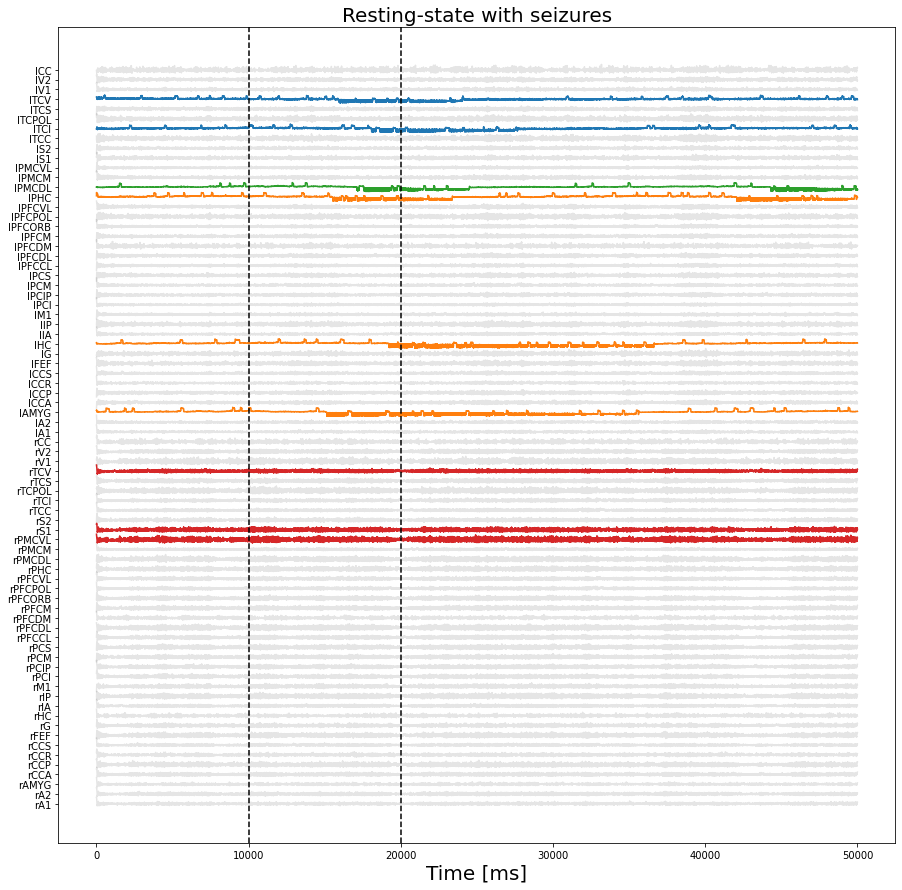

In [50]:
# Plot time series.
fig2 = plt.figure(figsize=(15,15))
plt.plot(DATA_2[:, :] + r_[:nregions], 'k', alpha=0.1)
plt.yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=10)

EZs = [62, 47, 40]
for ie, ez in enumerate(EZs):
    plt.plot(DATA_2[:, EZs[ie]] + EZs[ie], 'C1')
PZs = [69, 72]
for ip, pz in enumerate(PZs):
    plt.plot(DATA_2[:, PZs[ip]] + PZs[ip], 'C0')
    
plt.plot(DATA_2[:,63]+63,'C2')

STs = [27, 28, 34]
for ip, pz in enumerate(STs):
    plt.plot(DATA_2[:, STs[ip]] + STs[ip], 'C3')
    
plt.axvline(x=20000, color='k', linestyle='--')
plt.axvline(x=10000, color='k', linestyle='--')
    
plt.title('Resting-state with seizures', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)

plt.show()

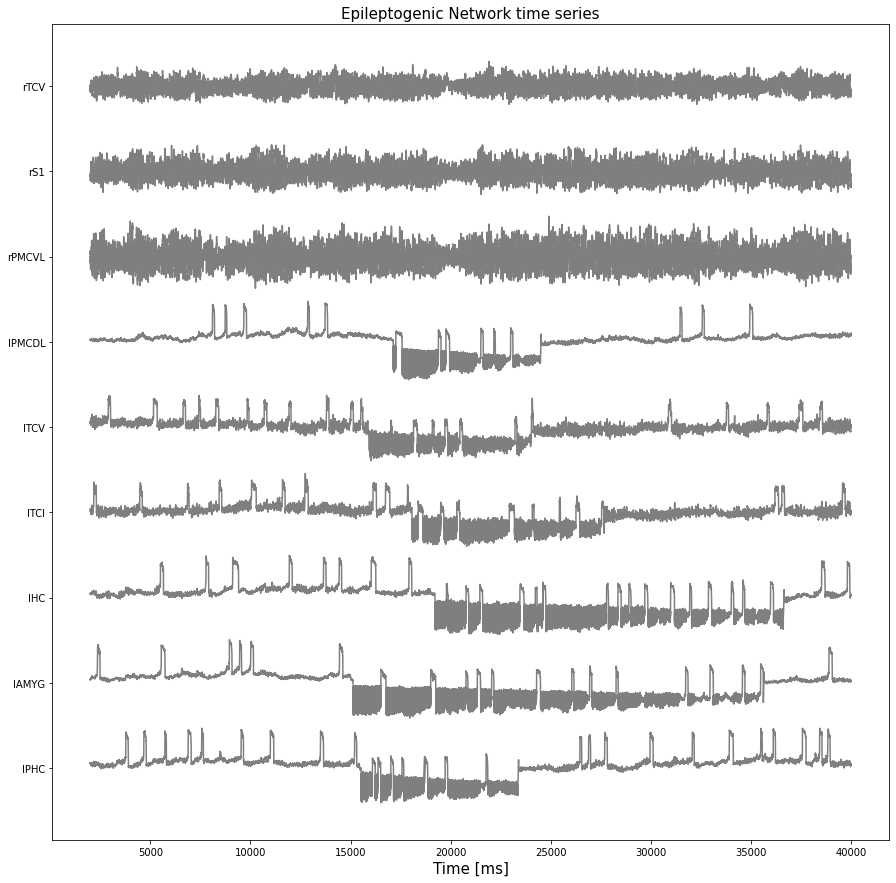

In [51]:
# Zoom.
EN = [62, 40, 47, 69, 72, 63,27, 28,34]
idx = np.arange(len(EN))

fig2 = plt.figure(figsize=(15,15))
for ie, en in enumerate(EN):
    plt.plot(np.arange(2000, 40000), DATA_2[2000:40000, EN[ie]] + idx[ie], 'k', alpha=0.5)
plt.title('Epileptogenic Network time series', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)
plt.yticks(np.arange(len(EN)), con.region_labels[EN])

plt.show()